In [142]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


data_folder = '../data/'
filename_small_movements = "record-[2023.12.04-14.29.07].gdf"


left_hand_event = "769"
right_hand_event = "770"
end_of_trial_event = "800"

event_ids = dict(left=1, right=2, rest=3)


In [151]:
raw = mne.io.read_raw_gdf(data_folder + filename_small_movements,
                             preload=True)
raw = raw.drop_channels("Channel 1").pick(["EX 1", "EX 2", "EX 3", "EX 4"])
raw = raw.set_eeg_reference()
raw = raw.set_channel_types(dict.fromkeys(raw.ch_names, "emg"))

# raw = raw.notch_filter(50, picks='emg', method='iir', phase='forward') # Multiple notches only implemented for FIR

# raw = raw.filter(30, 500, picks='emg', method='iir', phase='forward')
events, _ = mne.events_from_annotations(raw, event_id={left_hand_event: 1, right_hand_event: 2, end_of_trial_event: 3})
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,0x00000000
Digitized points,Not available
Good channels,4 EMG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


/var/folders/lm/ht2dkcld0tn4b4c0hqznvyfr0000gn/T/ipykernel_38795/93136417.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(picks='emg').plot(picks='emg')
/Users/ivopascal/.local/share/virtualenvs/emg_classifier-ojuTnE_B/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


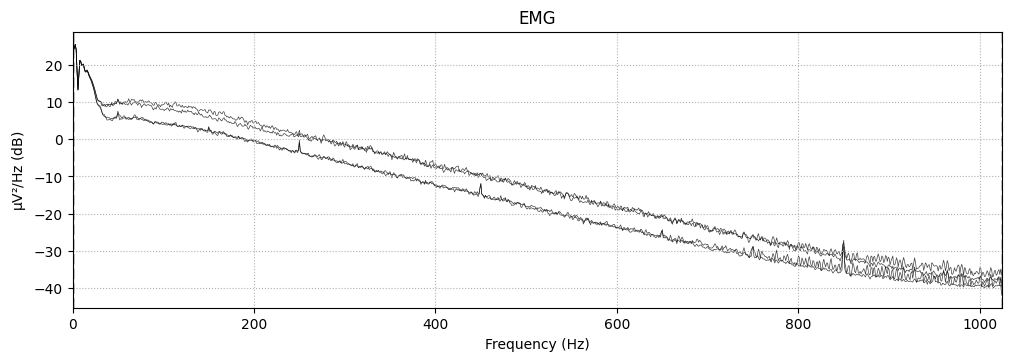

In [177]:


raw.compute_psd(picks='emg').plot(picks='emg')
plt.show()

In [239]:
import scipy
SFREQ = 2048
filters = [
    mne.filter.create_filter(raw.get_data(), l_freq=30, h_freq=500, method='iir',
                             phase='forward', sfreq=raw.info['sfreq']),
    mne.filter.create_filter(raw.get_data(), l_freq=51, h_freq=49, method='iir',
                             phase='forward', sfreq=raw.info['sfreq']),
]

zis = [
    scipy.signal.sosfilt_zi(filters[0]['sos']).reshape(4, 1, 2).repeat(repeats=4, axis=1),
    scipy.signal.sosfilt_zi(filters[1]['sos']).reshape(4, 1, 2).repeat(repeats=4, axis=1)
]

zi = scipy.signal.sosfilt_zi(filters[0]['sos'])

In [240]:
print(filters[0]['sos'].shape)
print(zi.shape)

(4, 6)
(4, 2)


In [241]:
zi = zi.reshape(4, 1, 2).repeat(repeats=4, axis=1)

In [242]:
zi.shape

(4, 4, 2)

In [243]:
raw_data.shape

(4, 882816)

In [244]:
filters[0]

{'order': 4,
 'ftype': 'butter',
 'output': 'sos',
 'padlen': 167,
 'sos': array([[ 0.07183004,  0.14366008,  0.07183004,  1.        , -0.12841282,
          0.05245438],
        [ 1.        ,  2.        ,  1.        ,  1.        , -0.07218575,
          0.4802015 ],
        [ 1.        , -2.        ,  1.        ,  1.        , -1.82430137,
          0.833511  ],
        [ 1.        , -2.        ,  1.        ,  1.        , -1.92827213,
          0.93666763]])}

/var/folders/lm/ht2dkcld0tn4b4c0hqznvyfr0000gn/T/ipykernel_38795/1806304469.py:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_2.compute_psd(picks='emg').plot(picks='emg')
/Users/ivopascal/.local/share/virtualenvs/emg_classifier-ojuTnE_B/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


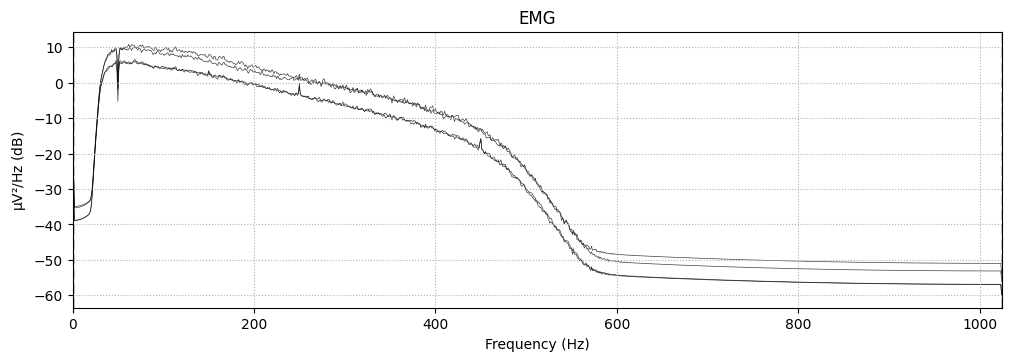

In [253]:
raw_data = raw.get_data()
interval = 1
for i in range(0, raw_data.shape[1], interval):
    raw_data[:, i: i+interval], zis[0] = scipy.signal.sosfilt(filters[0]['sos'],  raw_data[:, i: i+interval], zi=zis[0], axis=1)
    raw_data[:, i: i+interval], zis[1] = scipy.signal.sosfilt(filters[1]['sos'],  raw_data[:, i: i+interval], zi=zis[1], axis=1)

raw_2 = mne.io.RawArray(raw_data, raw.info)
raw_2.compute_psd(picks='emg').plot(picks='emg')

In [206]:
raw_data.shape[1]

882816

In [192]:
raw_data = scipy.signal.sosfilt(filters[0]['sos'],  raw.get_data())

In [193]:
raw_data.shape

(4, 882816)

In [234]:
raw_2 = mne.io.RawArray(raw_data, raw.info)
raw_2

Measurement date,Unknown
Experimenter,Unknown
Participant,0x00000000
Digitized points,Not available
Good channels,4 EMG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


/var/folders/lm/ht2dkcld0tn4b4c0hqznvyfr0000gn/T/ipykernel_38795/514385882.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_2.compute_psd(picks='emg').plot(picks='emg')
/Users/ivopascal/.local/share/virtualenvs/emg_classifier-ojuTnE_B/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


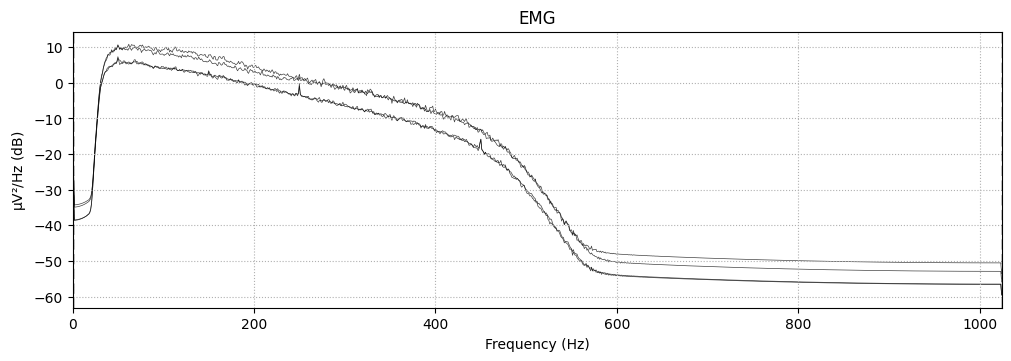

In [235]:
raw_2.compute_psd(picks='emg').plot(picks='emg')
plt.show()

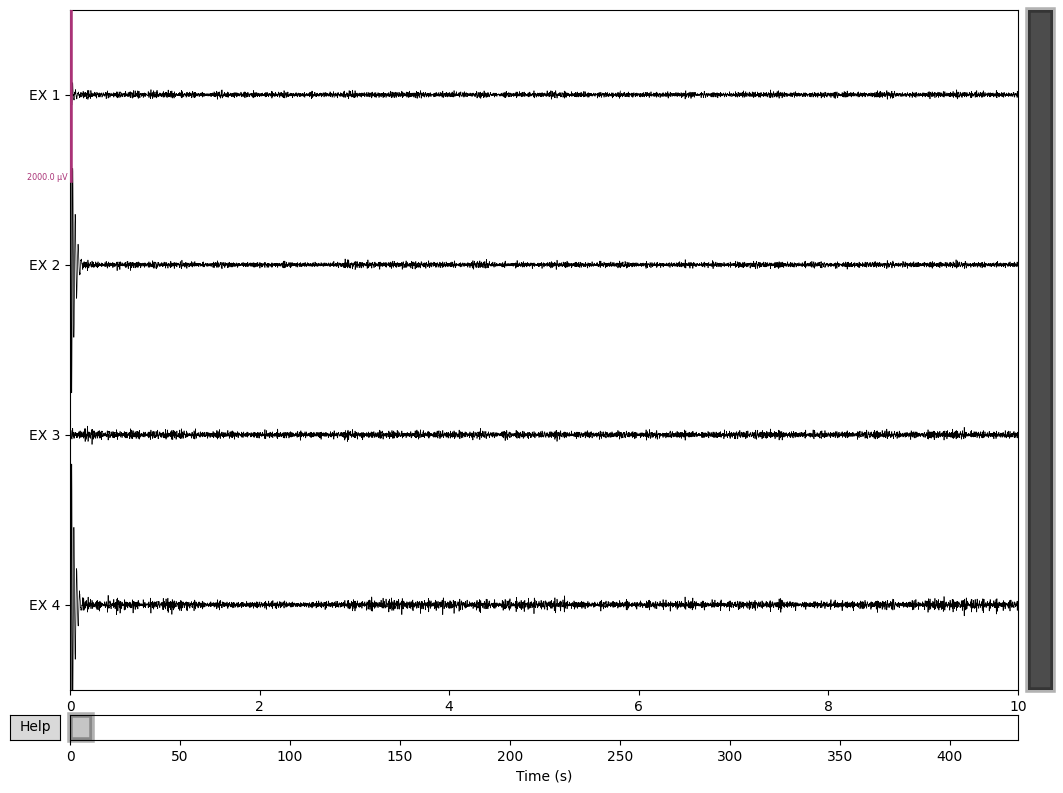

In [196]:
raw_2.plot()
plt.show()

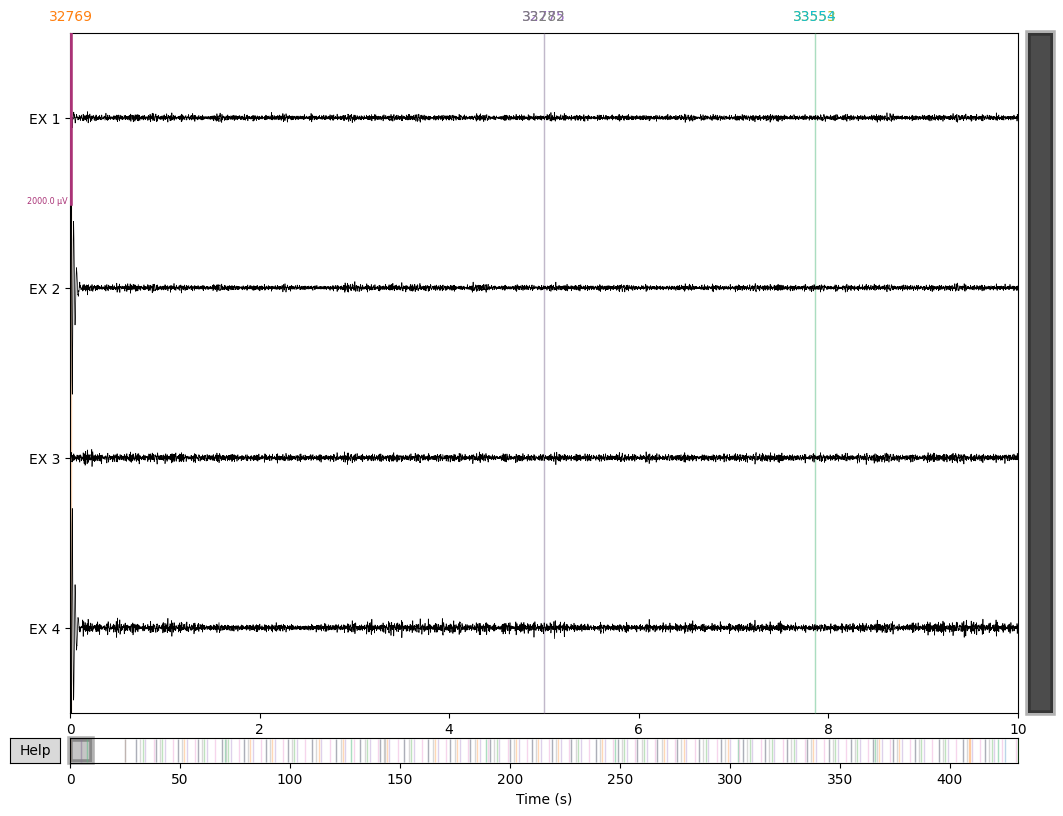

In [197]:
raw.plot()
plt.show()

In [198]:
cue_time = 1.25
move_time = 3.75

raw_normal = raw.filter(30, 500, picks='emg', method='iir', phase='forward')

epochs = mne.Epochs(
    raw_2,
    events,
    event_ids,
    cue_time,
    cue_time + move_time,
    baseline=None,
    preload=True,
)

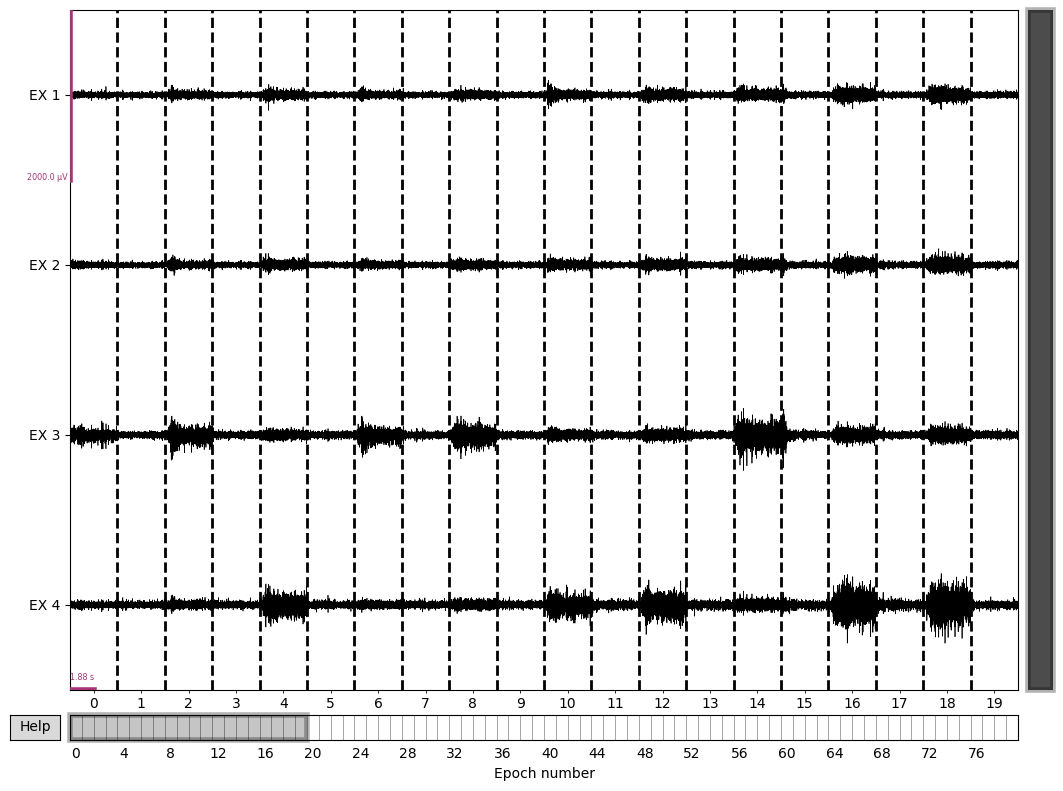

In [199]:
epochs.plot(picks='emg', events=events) 
plt.show() # This actually looks quite good. If we focus on EX3 and EX4 we can clearly distinguish left, right and rest

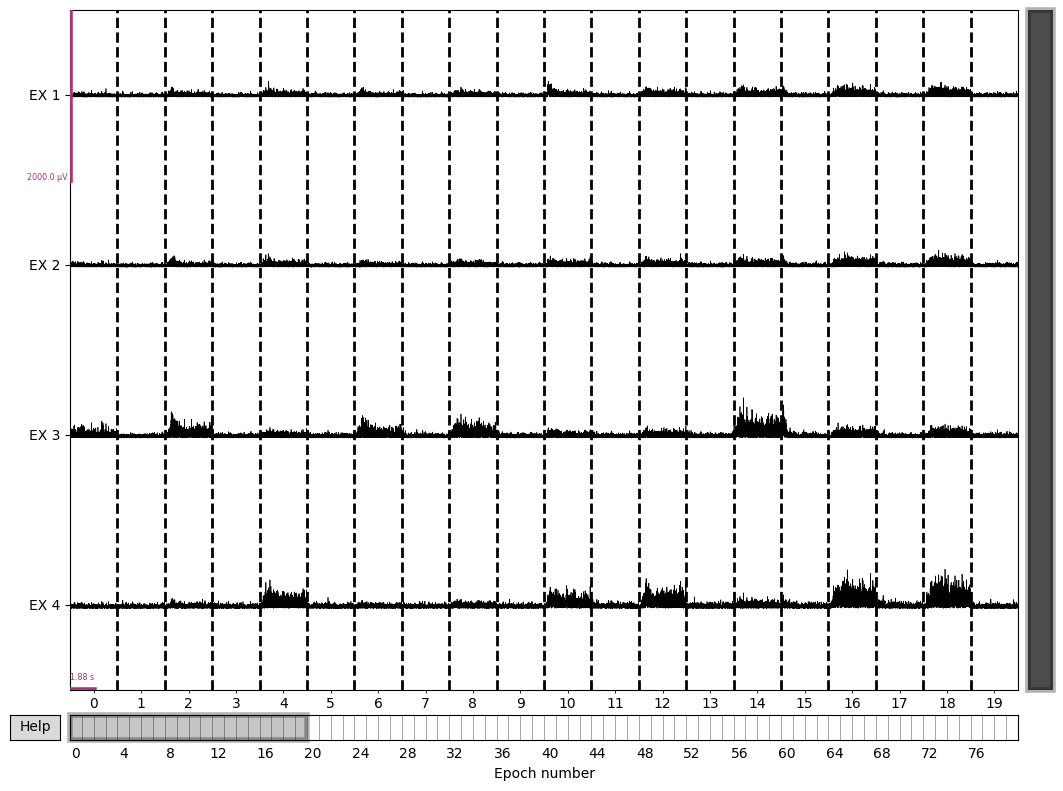

/var/folders/lm/ht2dkcld0tn4b4c0hqznvyfr0000gn/T/ipykernel_38795/1357148570.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = hilbert_epochs.get_data()


In [200]:
hilbert_epochs = epochs.apply_hilbert(envelope=True, picks='emg')
hilbert_epochs.plot(picks='emg')
plt.show()
X = hilbert_epochs.get_data()
y = hilbert_epochs.events[:, -1] - 1
X = X.mean(axis=2)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.75)

In [201]:
X_train

array([[1.90574974e-05, 1.93318401e-05, 2.17674049e-05, 2.09954947e-05],
       [1.68478349e-05, 1.62737077e-05, 1.95648722e-05, 2.06291624e-05],
       [2.01792438e-05, 1.97907447e-05, 2.22430901e-05, 2.32618208e-05],
       [3.50268722e-05, 3.54524424e-05, 8.55036003e-05, 3.46664887e-05],
       [3.48997935e-05, 3.55476626e-05, 3.59335962e-05, 8.13289588e-05],
       [3.39214869e-05, 3.33298327e-05, 8.05385963e-05, 3.54469588e-05],
       [3.82424580e-05, 3.93843028e-05, 3.90143593e-05, 9.05914164e-05],
       [1.90858966e-05, 1.91784350e-05, 2.29944367e-05, 2.16202961e-05],
       [1.99083083e-05, 2.01648923e-05, 2.25035966e-05, 2.12809748e-05],
       [3.32786249e-05, 3.05563359e-05, 3.34700882e-05, 6.53194356e-05],
       [1.76788951e-05, 1.87120861e-05, 2.01929073e-05, 2.06276047e-05],
       [1.84887922e-05, 1.92776415e-05, 2.25009760e-05, 2.16774243e-05],
       [3.36164268e-05, 3.24087981e-05, 8.38295927e-05, 3.34633902e-05],
       [4.43124406e-05, 4.30899856e-05, 4.38469686e

In [202]:
model = LDA()
for i in range(4):
    model.fit(X_train[:, i].reshape(-1, 1), y_train)
    print(f"Performance using only EX {i + 1}")
    print(classification_report(y_test, model.predict(X_test[:, i].reshape(-1, 1)), target_names=['Left', 'Right', 'Rest']))



Performance using only EX 1
              precision    recall  f1-score   support

        Left       0.80      0.75      0.77        16
       Right       0.69      0.60      0.64        15
        Rest       0.91      1.00      0.95        29

    accuracy                           0.83        60
   macro avg       0.80      0.78      0.79        60
weighted avg       0.82      0.83      0.83        60

Performance using only EX 2
              precision    recall  f1-score   support

        Left       0.86      0.75      0.80        16
       Right       0.71      0.67      0.69        15
        Rest       0.91      1.00      0.95        29

    accuracy                           0.85        60
   macro avg       0.83      0.81      0.81        60
weighted avg       0.85      0.85      0.85        60

Performance using only EX 3
              precision    recall  f1-score   support

        Left       0.83      0.94      0.88        16
       Right       1.00      0.80      0.89  

In [182]:
model.fit(X_train, y_train)
print(f"Performance using all channels")

print(classification_report(y_test, model.predict(X_test), target_names=['Left', 'Right', 'Rest']))


Performance using all channels
              precision    recall  f1-score   support

        Left       1.00      1.00      1.00        12
       Right       1.00      1.00      1.00        16
        Rest       1.00      1.00      1.00        32

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [112]:
model.score(X_test, y_test)

0.48333333333333334

In [113]:
from sklearn.model_selection import cross_val_score

def accuracy_for_time(t):
    
    cue_time = 1.25
    move_time = 3.75

    if t > move_time:
        return
    lost_time = move_time - t

    cue_time = cue_time + lost_time / 2 # + because we want to move forward in time
    move_time = move_time - lost_time 

    epochs = mne.Epochs(
        raw,
        events,
        event_ids,
        cue_time,
        cue_time + move_time,
        baseline=None,
        preload=True,
    )

    hilbert_epochs = epochs.apply_hilbert(envelope=True, picks='emg')
    X = hilbert_epochs.get_data(copy=True)
    y = hilbert_epochs.events[:, -1] - 1
    
    X = X.mean(axis=2)

    return cross_val_score(model, X, y, cv=10).mean()
mne.set_log_level("WARNING")

ts = np.arange(0, 3.75, 0.05)
acc = [accuracy_for_time(t) for t in ts]

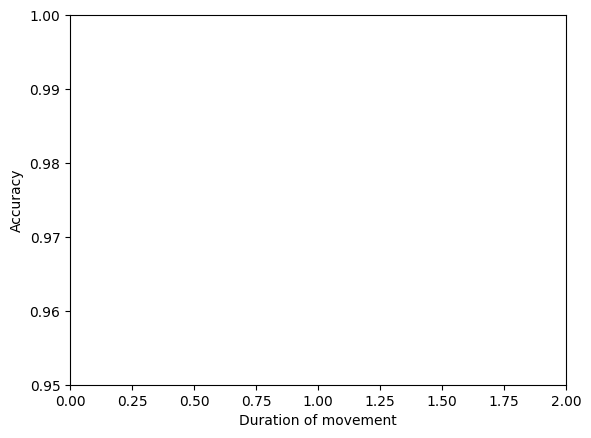

In [114]:
plt.plot(ts, acc)
plt.xlabel("Duration of movement")
plt.ylabel("Accuracy")
plt.xlim(0.0, 2)
plt.ylim(0.95, 1.0)
plt.show()

In [30]:
accuracy_for_time(2)

0.9875

In [20]:
acc

[0.7,
 0.975,
 0.9625,
 0.9625,
 0.9625,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.975,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875,
 0.9875]